# 請結合前面的知識與程式碼，比較不同的 optimizer 與 learning rate 組合對訓練的結果與影響
### 常見的 optimizer 包含
* SGD
* RMSprop
* AdaGrad
* Adam

Ans:
SGD 收斂雖慢 但最終loss沒有像 RMSprop及Adam的validate set的loss到訓練後期反而變大
並且lr 在0.1時收斂最快, 0.001及 0.00001 愈小愈慢

AdaGrad無論 learning 為 0.1, 0.001, 0.00001,  都無法收斂



In [1]:
import os
import keras

# Disable GPU
os.environ["CUDA_VISIBLE_DEVICES"] = ""

Using TensorFlow backend.


In [2]:
train, test = keras.datasets.cifar10.load_data()

In [3]:
## 資料前處理
def preproc_x(x, flatten=True):
    x = x / 255.
    if flatten:
        x = x.reshape((len(x), -1))
    return x

def preproc_y(y, num_classes=10):
    if y.shape[-1] == 1:
        y = keras.utils.to_categorical(y, num_classes)
    return y    

In [4]:
x_train, y_train = train
x_test, y_test = test

# Preproc the inputs
x_train = preproc_x(x_train)
x_test = preproc_x(x_test)

# Preprc the outputs
y_train = preproc_y(y_train)
y_test = preproc_y(y_test)

In [5]:
def build_mlp(input_shape, output_units=10, num_neurons=[512, 256, 128]):
    input_layer = keras.layers.Input(input_shape)
    
    for i, n_units in enumerate(num_neurons):
        if i == 0:
            x = keras.layers.Dense(units=n_units, activation="relu", name="hidden_layer"+str(i+1))(input_layer)
        else:
            x = keras.layers.Dense(units=n_units, activation="relu", name="hidden_layer"+str(i+1))(x)
    
    out = keras.layers.Dense(units=output_units, activation="softmax", name="output")(x)
    
    model = keras.models.Model(inputs=[input_layer], outputs=[out])
    return model

In [6]:
## 超參數設定
"""
Set your required experiment parameters
"""
LEARNING_RATE = [1e-1, 1e-3, 1e-5]
EPOCHS = 50
BATCH_SIZE = 256
MOMENTUM = 0.95

Optimizer = ['SGD','RMSprop','AdaGrad','Adam']


In [7]:
results = {}
"""
建立你的訓練與實驗迴圈並蒐集資料
"""
for opt_str in Optimizer:
    for lr in LEARNING_RATE:
        keras.backend.clear_session() # 把舊的 Graph 清掉
        print("Experiment with LR = %.6f" % (lr))
        model = build_mlp(input_shape=x_train.shape[1:])
        model.summary()
        
        if opt_str == 'SGD':
            optimizer = keras.optimizers.SGD(lr=lr, nesterov=True, momentum=MOMENTUM)
        elif opt_str =='RMSprop':
            optimizer = keras.optimizers.RMSprop(lr=0.001, epsilon=None, decay=0.0)
        elif opt_str =='AdaGrad':
            optimizer = keras.optimizers.Adagrad(lr=0.01, epsilon=None, decay=0.0)
        elif opt_str =='Adam':
            optimizer = keras.optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
        
        
        model.compile(loss="categorical_crossentropy", metrics=["accuracy"], optimizer=optimizer)

        model.fit(x_train, y_train, 
                  epochs=EPOCHS, 
                  batch_size=BATCH_SIZE, 
                  validation_data=(x_test, y_test), 
                  shuffle=True)

        # Collect results
        train_loss = model.history.history["loss"]
        valid_loss = model.history.history["val_loss"]
        train_acc = model.history.history["acc"]
        valid_acc = model.history.history["val_acc"]

        exp_name_tag = "exp-lr-%s-opt-%s" % (str(lr),str(opt_str))
        results[exp_name_tag] = {'train-loss': train_loss,
                                 'valid-loss': valid_loss,
                                 'train-acc': train_acc,
                                 'valid-acc': valid_acc}

W0720 18:46:12.853984 10288 deprecation_wrapper.py:119] From C:\ProgramData\Anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:95: The name tf.reset_default_graph is deprecated. Please use tf.compat.v1.reset_default_graph instead.

W0720 18:46:12.854988 10288 deprecation_wrapper.py:119] From C:\ProgramData\Anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:98: The name tf.placeholder_with_default is deprecated. Please use tf.compat.v1.placeholder_with_default instead.

W0720 18:46:12.874978 10288 deprecation_wrapper.py:119] From C:\ProgramData\Anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:102: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0720 18:46:12.877972 10288 deprecation_wrapper.py:119] From C:\ProgramData\Anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0720 18:46:12.883976 10288 

Experiment with LR = 0.100000
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               131328    
_________________________________________________________________
hidden_layer3 (Dense)        (None, 128)               32896     
_________________________________________________________________
output (Dense)               (None, 10)                1290      
Total params: 1,738,890
Trainable params: 1,738,890
Non-trainable params: 0
_________________________________________________________________


W0720 18:46:13.134976 10288 deprecation.py:323] From C:\ProgramData\Anaconda3\lib\site-packages\tensorflow\python\ops\math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Train on 50000 samples, validate on 10000 samples
Epoch 1/50
50000/50000 [==============================] - 14s 282us/step - loss: 2.0767 - acc: 0.2215 - val_loss: 1.9933 - val_acc: 0.2758
Epoch 2/50
50000/50000 [==============================] - 14s 277us/step - loss: 1.8289 - acc: 0.3331 - val_loss: 1.8302 - val_acc: 0.3188
Epoch 3/50
50000/50000 [==============================] - 14s 288us/step - loss: 1.7866 - acc: 0.3489 - val_loss: 1.7808 - val_acc: 0.3487
Epoch 4/50
50000/50000 [==============================] - 14s 275us/step - loss: 1.7298 - acc: 0.3765 - val_loss: 1.7690 - val_acc: 0.3752
Epoch 5/50
50000/50000 [==============================] - 13s 267us/step - loss: 1.7004 - acc: 0.3865 - val_loss: 1.6964 - val_acc: 0.3893
Epoch 6/50
50000/50000 [==============================] - 14s 270us/step - loss: 1.6839 - acc: 0.3994 - val_loss: 1.7336 - val_acc: 0.3868
Epoch 7/50
50000/50000 [==============================] - 13s 269us/step - loss: 1.6589 - acc: 0.4085 - val_loss: 1.

50000/50000 [==============================] - 14s 280us/step - loss: 2.0335 - acc: 0.2731 - val_loss: 1.8644 - val_acc: 0.3481
Epoch 2/50
50000/50000 [==============================] - 14s 275us/step - loss: 1.8023 - acc: 0.3676 - val_loss: 1.7493 - val_acc: 0.3880
Epoch 3/50
50000/50000 [==============================] - 14s 275us/step - loss: 1.7174 - acc: 0.3990 - val_loss: 1.6923 - val_acc: 0.4020
Epoch 4/50
50000/50000 [==============================] - 14s 274us/step - loss: 1.6583 - acc: 0.4231 - val_loss: 1.6365 - val_acc: 0.4278
Epoch 5/50
50000/50000 [==============================] - 14s 277us/step - loss: 1.6103 - acc: 0.4374 - val_loss: 1.5974 - val_acc: 0.4430
Epoch 6/50
50000/50000 [==============================] - 14s 276us/step - loss: 1.5718 - acc: 0.4505 - val_loss: 1.5643 - val_acc: 0.4485
Epoch 7/50
50000/50000 [==============================] - 14s 276us/step - loss: 1.5392 - acc: 0.4586 - val_loss: 1.5423 - val_acc: 0.4584
Epoch 8/50
50000/50000 [==============

Epoch 2/50
50000/50000 [==============================] - 14s 275us/step - loss: 2.2821 - acc: 0.1326 - val_loss: 2.2677 - val_acc: 0.1443
Epoch 3/50
50000/50000 [==============================] - 14s 273us/step - loss: 2.2594 - acc: 0.1539 - val_loss: 2.2477 - val_acc: 0.1637
Epoch 4/50
50000/50000 [==============================] - 14s 274us/step - loss: 2.2410 - acc: 0.1761 - val_loss: 2.2304 - val_acc: 0.1807
Epoch 5/50
50000/50000 [==============================] - 14s 274us/step - loss: 2.2243 - acc: 0.1895 - val_loss: 2.2144 - val_acc: 0.1950
Epoch 6/50
50000/50000 [==============================] - 14s 274us/step - loss: 2.2089 - acc: 0.2042 - val_loss: 2.1996 - val_acc: 0.2076
Epoch 7/50
50000/50000 [==============================] - 14s 274us/step - loss: 2.1945 - acc: 0.2160 - val_loss: 2.1855 - val_acc: 0.2160
Epoch 8/50
50000/50000 [==============================] - 14s 276us/step - loss: 2.1806 - acc: 0.2243 - val_loss: 2.1719 - val_acc: 0.2272
Epoch 9/50
50000/50000 [===

Epoch 3/50
50000/50000 [==============================] - 16s 317us/step - loss: 1.7793 - acc: 0.3631 - val_loss: 1.7031 - val_acc: 0.3885
Epoch 4/50
50000/50000 [==============================] - 16s 316us/step - loss: 1.7062 - acc: 0.3915 - val_loss: 1.7612 - val_acc: 0.3629
Epoch 5/50
50000/50000 [==============================] - 16s 316us/step - loss: 1.6514 - acc: 0.4103 - val_loss: 1.7712 - val_acc: 0.3669
Epoch 6/50
50000/50000 [==============================] - 16s 315us/step - loss: 1.6051 - acc: 0.4268 - val_loss: 1.8435 - val_acc: 0.3589
Epoch 7/50
50000/50000 [==============================] - 16s 315us/step - loss: 1.5657 - acc: 0.4421 - val_loss: 1.7117 - val_acc: 0.3933
Epoch 8/50
50000/50000 [==============================] - 16s 316us/step - loss: 1.5292 - acc: 0.4553 - val_loss: 1.8415 - val_acc: 0.3514
Epoch 9/50
50000/50000 [==============================] - 16s 319us/step - loss: 1.5032 - acc: 0.4639 - val_loss: 1.5744 - val_acc: 0.4326
Epoch 10/50
50000/50000 [==

Epoch 4/50
50000/50000 [==============================] - 16s 320us/step - loss: 1.7035 - acc: 0.3896 - val_loss: 1.6876 - val_acc: 0.4041
Epoch 5/50
50000/50000 [==============================] - 16s 318us/step - loss: 1.6490 - acc: 0.4091 - val_loss: 1.7041 - val_acc: 0.3894
Epoch 6/50
50000/50000 [==============================] - 16s 319us/step - loss: 1.6039 - acc: 0.4276 - val_loss: 1.6016 - val_acc: 0.4286
Epoch 7/50
50000/50000 [==============================] - 16s 319us/step - loss: 1.5644 - acc: 0.4415 - val_loss: 1.5925 - val_acc: 0.4382
Epoch 8/50
50000/50000 [==============================] - 16s 319us/step - loss: 1.5319 - acc: 0.4533 - val_loss: 1.5568 - val_acc: 0.4391
Epoch 9/50
50000/50000 [==============================] - 16s 319us/step - loss: 1.4992 - acc: 0.4650 - val_loss: 1.5525 - val_acc: 0.4483
Epoch 10/50
50000/50000 [==============================] - 16s 320us/step - loss: 1.4713 - acc: 0.4730 - val_loss: 1.5086 - val_acc: 0.4716
Epoch 11/50
50000/50000 [=

Epoch 5/50
50000/50000 [==============================] - 16s 317us/step - loss: 1.6585 - acc: 0.4088 - val_loss: 1.6888 - val_acc: 0.3925
Epoch 6/50
50000/50000 [==============================] - 16s 318us/step - loss: 1.6181 - acc: 0.4222 - val_loss: 1.5957 - val_acc: 0.4273
Epoch 7/50
50000/50000 [==============================] - 16s 319us/step - loss: 1.5755 - acc: 0.4359 - val_loss: 1.6753 - val_acc: 0.4012
Epoch 8/50
50000/50000 [==============================] - 15s 309us/step - loss: 1.5376 - acc: 0.4505 - val_loss: 2.0838 - val_acc: 0.3076
Epoch 9/50
50000/50000 [==============================] - 15s 309us/step - loss: 1.5091 - acc: 0.4606 - val_loss: 1.6696 - val_acc: 0.3967
Epoch 10/50
50000/50000 [==============================] - 15s 307us/step - loss: 1.4752 - acc: 0.4705 - val_loss: 1.6894 - val_acc: 0.4060
Epoch 11/50
50000/50000 [==============================] - 15s 307us/step - loss: 1.4486 - acc: 0.4810 - val_loss: 1.5104 - val_acc: 0.4598
Epoch 12/50
50000/50000 [

Epoch 6/50
50000/50000 [==============================] - 14s 284us/step - loss: 14.5063 - acc: 0.1000 - val_loss: 14.5063 - val_acc: 0.1000
Epoch 7/50
50000/50000 [==============================] - 15s 294us/step - loss: 14.5063 - acc: 0.1000 - val_loss: 14.5063 - val_acc: 0.1000
Epoch 8/50
50000/50000 [==============================] - 14s 285us/step - loss: 14.5063 - acc: 0.1000 - val_loss: 14.5063 - val_acc: 0.1000
Epoch 9/50
50000/50000 [==============================] - 14s 288us/step - loss: 14.5063 - acc: 0.1000 - val_loss: 14.5063 - val_acc: 0.1000
Epoch 10/50
50000/50000 [==============================] - 14s 286us/step - loss: 14.5063 - acc: 0.1000 - val_loss: 14.5063 - val_acc: 0.1000
Epoch 11/50
50000/50000 [==============================] - 14s 286us/step - loss: 14.5063 - acc: 0.1000 - val_loss: 14.5063 - val_acc: 0.1000
Epoch 12/50
50000/50000 [==============================] - 14s 285us/step - loss: 14.5063 - acc: 0.1000 - val_loss: 14.5063 - val_acc: 0.1000
Epoch 13/5

50000/50000 [==============================] - 14s 285us/step - loss: 14.5063 - acc: 0.1000 - val_loss: 14.5063 - val_acc: 0.1000
Epoch 7/50
50000/50000 [==============================] - 14s 285us/step - loss: 14.5063 - acc: 0.1000 - val_loss: 14.5063 - val_acc: 0.1000
Epoch 8/50
50000/50000 [==============================] - 14s 286us/step - loss: 14.5063 - acc: 0.1000 - val_loss: 14.5063 - val_acc: 0.1000
Epoch 9/50
50000/50000 [==============================] - 14s 287us/step - loss: 14.5063 - acc: 0.1000 - val_loss: 14.5063 - val_acc: 0.1000
Epoch 10/50
50000/50000 [==============================] - 14s 286us/step - loss: 14.5063 - acc: 0.1000 - val_loss: 14.5063 - val_acc: 0.1000
Epoch 11/50
50000/50000 [==============================] - 14s 286us/step - loss: 14.5063 - acc: 0.1000 - val_loss: 14.5063 - val_acc: 0.1000
Epoch 12/50
50000/50000 [==============================] - 14s 286us/step - loss: 14.5063 - acc: 0.1000 - val_loss: 14.5063 - val_acc: 0.1000
Epoch 13/50
50000/500

50000/50000 [==============================] - 14s 287us/step - loss: 14.5061 - acc: 0.1000 - val_loss: 14.5063 - val_acc: 0.1000
Epoch 7/50
50000/50000 [==============================] - 14s 288us/step - loss: 14.4967 - acc: 0.1003 - val_loss: 14.5063 - val_acc: 0.1000
Epoch 8/50
50000/50000 [==============================] - 15s 299us/step - loss: 14.5062 - acc: 0.1000 - val_loss: 14.5063 - val_acc: 0.1000
Epoch 9/50
50000/50000 [==============================] - 15s 308us/step - loss: 14.5062 - acc: 0.1000 - val_loss: 14.5063 - val_acc: 0.1000
Epoch 10/50
50000/50000 [==============================] - 15s 291us/step - loss: 14.5061 - acc: 0.1000 - val_loss: 14.5063 - val_acc: 0.1000
Epoch 11/50
50000/50000 [==============================] - 15s 302us/step - loss: 14.5061 - acc: 0.1000 - val_loss: 14.5063 - val_acc: 0.1000
Epoch 12/50
50000/50000 [==============================] - 15s 301us/step - loss: 14.5060 - acc: 0.1000 - val_loss: 14.5063 - val_acc: 0.1000
Epoch 13/50
50000/500

50000/50000 [==============================] - 17s 348us/step - loss: 1.4690 - acc: 0.4772 - val_loss: 1.4706 - val_acc: 0.4815
Epoch 7/50
50000/50000 [==============================] - 18s 352us/step - loss: 1.4228 - acc: 0.4941 - val_loss: 1.4317 - val_acc: 0.4920
Epoch 8/50
50000/50000 [==============================] - 18s 355us/step - loss: 1.3968 - acc: 0.5036 - val_loss: 1.4556 - val_acc: 0.4851
Epoch 9/50
50000/50000 [==============================] - 18s 354us/step - loss: 1.3817 - acc: 0.5091 - val_loss: 1.4454 - val_acc: 0.4903
Epoch 10/50
50000/50000 [==============================] - 18s 351us/step - loss: 1.3411 - acc: 0.5208 - val_loss: 1.4242 - val_acc: 0.4899
Epoch 11/50
50000/50000 [==============================] - 18s 352us/step - loss: 1.3202 - acc: 0.5294 - val_loss: 1.4066 - val_acc: 0.5031
Epoch 12/50
50000/50000 [==============================] - 18s 352us/step - loss: 1.2868 - acc: 0.5411 - val_loss: 1.3845 - val_acc: 0.5069
Epoch 13/50
50000/50000 [==========

Epoch 7/50
50000/50000 [==============================] - 18s 352us/step - loss: 1.4221 - acc: 0.4928 - val_loss: 1.4761 - val_acc: 0.4720
Epoch 8/50
50000/50000 [==============================] - 18s 354us/step - loss: 1.3985 - acc: 0.5007 - val_loss: 1.4415 - val_acc: 0.4887
Epoch 9/50
50000/50000 [==============================] - 18s 351us/step - loss: 1.3772 - acc: 0.5110 - val_loss: 1.4741 - val_acc: 0.4758
Epoch 10/50
50000/50000 [==============================] - 18s 350us/step - loss: 1.3508 - acc: 0.5170 - val_loss: 1.4690 - val_acc: 0.4809
Epoch 11/50
50000/50000 [==============================] - 18s 353us/step - loss: 1.3215 - acc: 0.5268 - val_loss: 1.4538 - val_acc: 0.4898
Epoch 12/50
50000/50000 [==============================] - 18s 355us/step - loss: 1.3004 - acc: 0.5389 - val_loss: 1.3825 - val_acc: 0.5144
Epoch 13/50
50000/50000 [==============================] - 18s 353us/step - loss: 1.2750 - acc: 0.5468 - val_loss: 1.4745 - val_acc: 0.4809
Epoch 14/50
50000/50000

Epoch 8/50
50000/50000 [==============================] - 17s 349us/step - loss: 1.4057 - acc: 0.4988 - val_loss: 1.5084 - val_acc: 0.4675
Epoch 9/50
50000/50000 [==============================] - 18s 351us/step - loss: 1.3805 - acc: 0.5079 - val_loss: 1.4565 - val_acc: 0.4861
Epoch 10/50
50000/50000 [==============================] - 17s 349us/step - loss: 1.3543 - acc: 0.5151 - val_loss: 1.4496 - val_acc: 0.4829
Epoch 11/50
50000/50000 [==============================] - 17s 349us/step - loss: 1.3325 - acc: 0.5212 - val_loss: 1.4249 - val_acc: 0.4967
Epoch 12/50
50000/50000 [==============================] - 17s 349us/step - loss: 1.3050 - acc: 0.5340 - val_loss: 1.4387 - val_acc: 0.4894
Epoch 13/50
50000/50000 [==============================] - 17s 347us/step - loss: 1.2791 - acc: 0.5435 - val_loss: 1.3935 - val_acc: 0.5097
Epoch 14/50
50000/50000 [==============================] - 18s 350us/step - loss: 1.2630 - acc: 0.5491 - val_loss: 1.4387 - val_acc: 0.4936
Epoch 15/50
50000/5000

In [14]:
len(results)

12

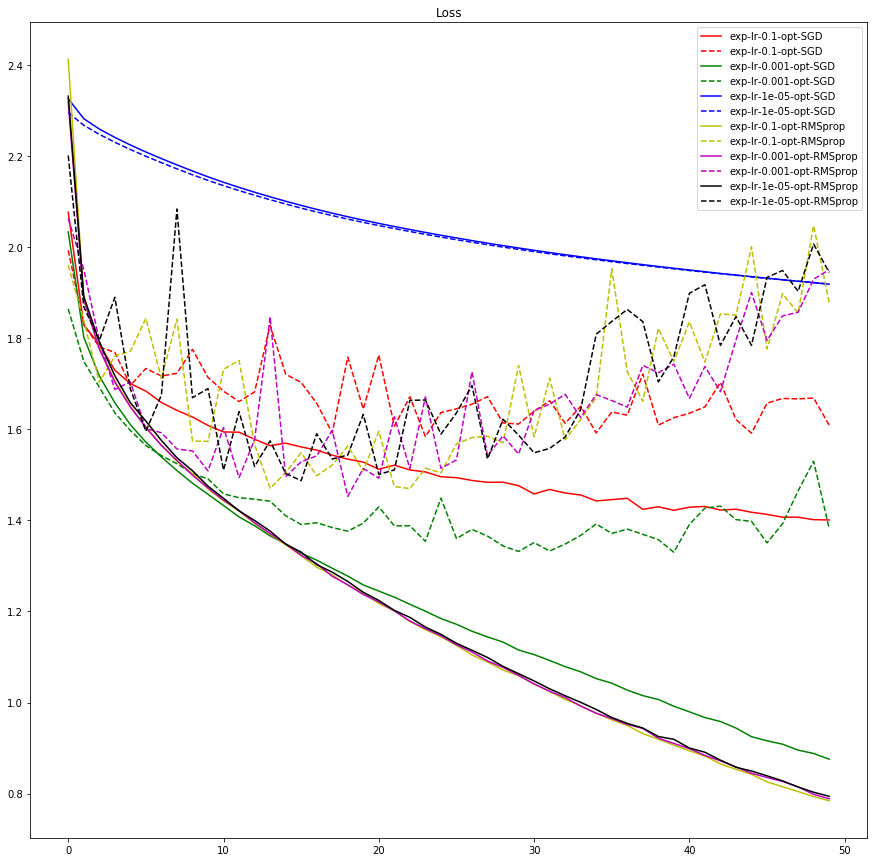

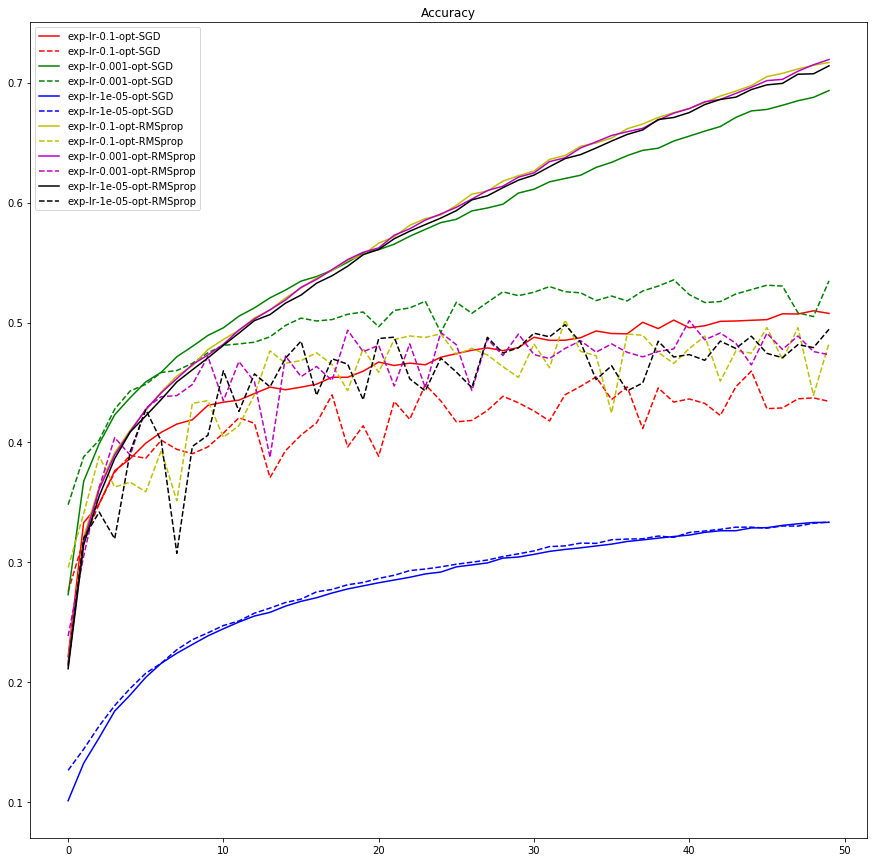

In [18]:
import matplotlib.pyplot as plt
%matplotlib inline

"""
將實驗結果繪出
"""
color_bar = ["r", "g", "b", "y", "m", "k",'black','gray','lime','turquoise','slateblue','mediumslateblue','wheat','darkgoldenrod']
#color_bar = ['C0', 'C1', 'C2', 'C3', 'C4', 'C5', 'C6', 'C7', 'C8', 'C9', 'C10', 'C11', 'C12']


plt.figure(figsize=(15,15))
for i, cond in enumerate(results.keys()):
    if i<6:
        plt.plot(range(len(results[cond]['train-loss'])),results[cond]['train-loss'], '-', label=cond, color=color_bar[i])
        plt.plot(range(len(results[cond]['valid-loss'])),results[cond]['valid-loss'], '--', label=cond, color=color_bar[i])
plt.title("Loss")
plt.legend()
plt.show()

plt.figure(figsize=(15,15))
for i, cond in enumerate(results.keys()):
    if i<6:
        plt.plot(range(len(results[cond]['train-acc'])),results[cond]['train-acc'], '-', label=cond, color=color_bar[i])
        plt.plot(range(len(results[cond]['valid-acc'])),results[cond]['valid-acc'], '--', label=cond, color=color_bar[i])
plt.title("Accuracy")
plt.legend()
plt.show()

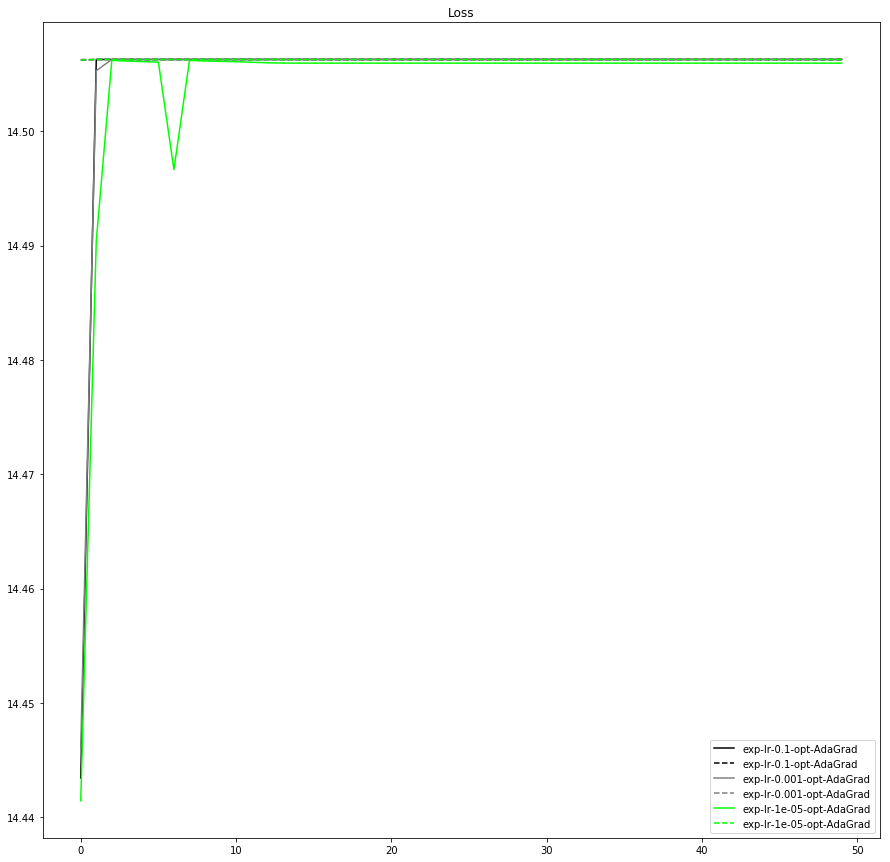

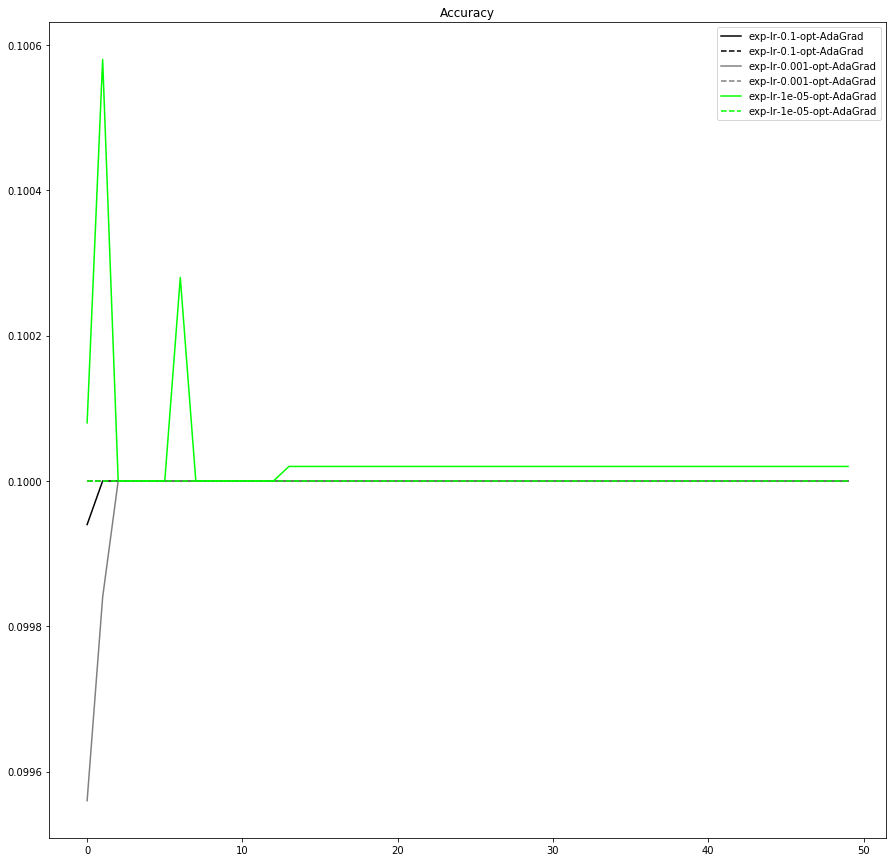

In [27]:
"""
將實驗結果繪出
"""
color_bar = ["r", "g", "b", "y", "m", "k",'black','gray','lime','turquoise','slateblue','mediumslateblue','wheat','darkgoldenrod']
#color_bar = ['C0', 'C1', 'C2', 'C3', 'C4', 'C5', 'C6', 'C7', 'C8', 'C9', 'C10', 'C11', 'C12']


plt.figure(figsize=(15,15))
for i, cond in enumerate(results.keys()):
    if i>=6 and i<9:
        plt.plot(range(len(results[cond]['train-loss'])),results[cond]['train-loss'], '-', label=cond, color=color_bar[i])
        plt.plot(range(len(results[cond]['valid-loss'])),results[cond]['valid-loss'], '--', label=cond, color=color_bar[i])
plt.title("Loss")
plt.legend()
plt.show()

plt.figure(figsize=(15,15))
for i, cond in enumerate(results.keys()):
    if i>=6 and i<9:
        plt.plot(range(len(results[cond]['train-acc'])),results[cond]['train-acc'], '-', label=cond, color=color_bar[i])
        plt.plot(range(len(results[cond]['valid-acc'])),results[cond]['valid-acc'], '--', label=cond, color=color_bar[i])
plt.title("Accuracy")
plt.legend()
plt.show()

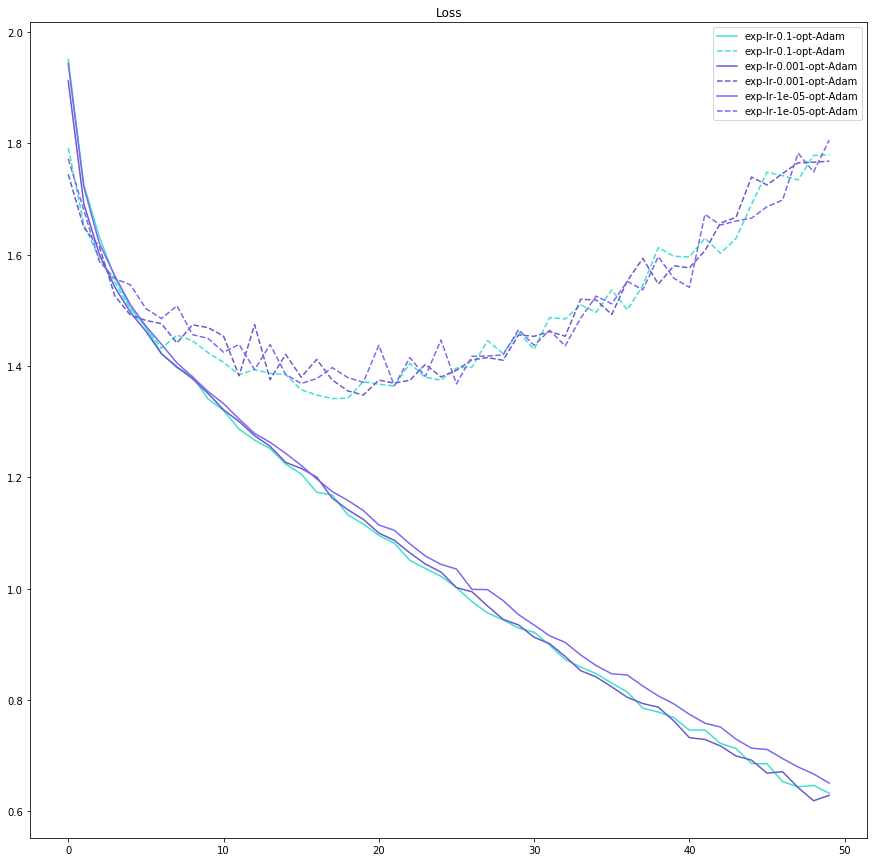

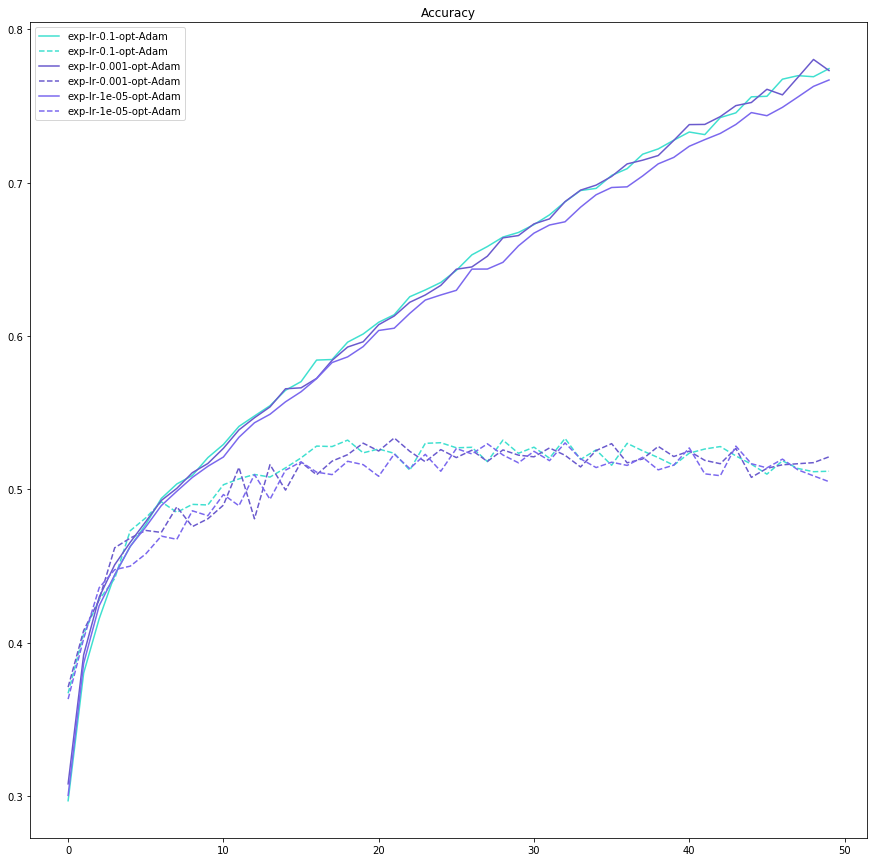

In [28]:
color_bar = ["r", "g", "b", "y", "m", "k",'black','gray','lime','turquoise','slateblue','mediumslateblue','wheat','darkgoldenrod']
#color_bar = ['C0', 'C1', 'C2', 'C3', 'C4', 'C5', 'C6', 'C7', 'C8', 'C9', 'C10', 'C11', 'C12']


plt.figure(figsize=(15,15))
for i, cond in enumerate(results.keys()):
    if i>=9:
        plt.plot(range(len(results[cond]['train-loss'])),results[cond]['train-loss'], '-', label=cond, color=color_bar[i])
        plt.plot(range(len(results[cond]['valid-loss'])),results[cond]['valid-loss'], '--', label=cond, color=color_bar[i])
plt.title("Loss")
plt.legend()
plt.show()

plt.figure(figsize=(15,15))
for i, cond in enumerate(results.keys()):
    if i>=9:
        plt.plot(range(len(results[cond]['train-acc'])),results[cond]['train-acc'], '-', label=cond, color=color_bar[i])
        plt.plot(range(len(results[cond]['valid-acc'])),results[cond]['valid-acc'], '--', label=cond, color=color_bar[i])
plt.title("Accuracy")
plt.legend()
plt.show()